# Binary Activity Classification

In this notebook, I'll try to split apart the data points, whose activities are continuously distributed, into two groups of "active" and "inactive" points. Then I'll examine how our features are correlated with this "activity," and try training a classifier to predict it.

For more details, check out the "Activity" section of the [Main Presentation](main-presentation.ipynb).

In [550]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
from guide.dataset import GuideDataset
from guide.plot_helpers import *
import random
import sklearn.tree
import sklearn.ensemble
import itertools

In [2]:
dataset = GuideDataset('data/example_guide_data_with_bowtie_with_mfold.tsv')
points = dataset.points
points = list(filter(lambda p: p.mfold_result().dG < 900, points)) # remove a small number of unfoldable points

In [557]:
def plot_activity_grid(title, points, ylim=8000):
    with figure_grid(3, 2, title) as fig:
        for d1, d2 in itertools.combinations([0, 7, 14], 2):
            for plx in ['base', 'plx']:
                fig.next_subplot()
                plot_activity(d1, d2, plx, points)
                plt.ylim(0, ylim)
                plt.axvline(0, color='red')
                plt.legend()

def compare_by(feature, bins=20, xrng=None, subplot=None):
    compare_point_groups_by(feature, active_points, same_gene_inactive_points, bins=bins, xrng=xrng, axis1=subplot)

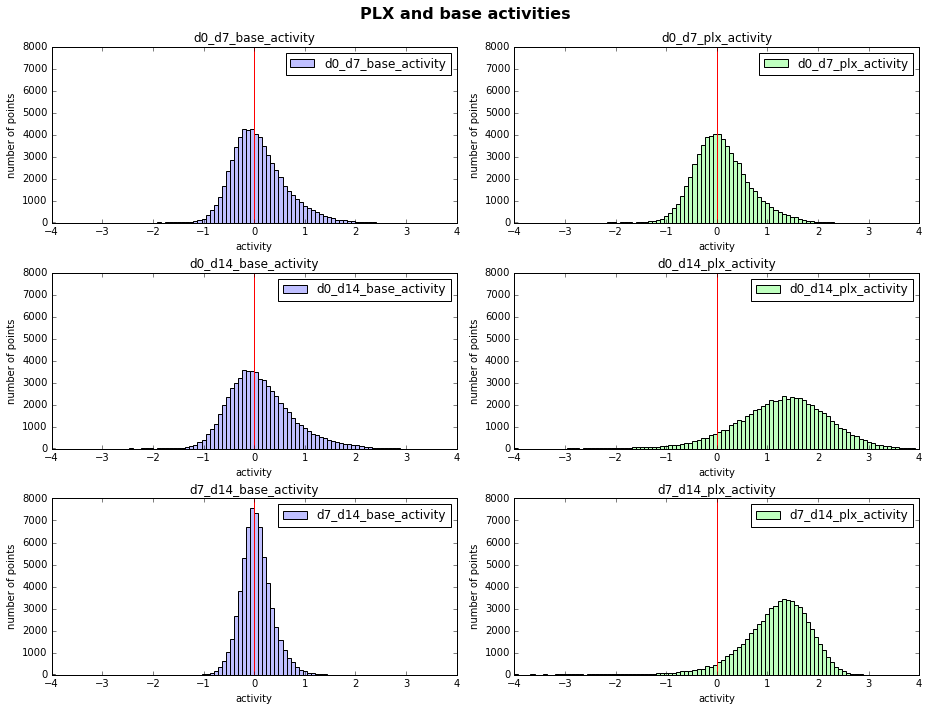

In [555]:
plot_activity_grid('PLX and base activities', points)

In [536]:
d7_d14_base_activities = [p.d7_d14_base_activity() for p in points]

sigma, mean = numpy.std(d7_d14_base_activities), numpy.mean(d7_d14_base_activities)

print('average activity', mean)
print('standard deviation', sigma)

# Consider points to be "active" if their week 1 activity is outside the range of their week 2 activity (by 3 sigma)
outside_d7_d14_range = lambda p: p.d0_d7_base_activity() > 3*sigma

# Instead of considering "inactive" all points whose week 1 activites are within the week 2 activity range,
# let's take it a step further and require them to be within that range but in the negative portion.
inside_d7_d14_range = lambda p: p.d0_d7_base_activity() < -sigma and p.d0_d7_base_activity() >= -3*sigma

active_points = list(filter(outside_d7_d14_range, points))
inactive_points = list(filter(inside_d7_d14_range, points))

print('out of', len(points), 'points, approximately', len(active_points), 'are active')
print('out of', len(points), 'points, approximately', len(inactive_points), 'are inactive')

active_point_genes = set([p.row['gene_name'] for p in active_points])
print('from the {} active points, there are {} genes'.format(len(active_points), len(active_point_genes)))

same_gene_inactive_points = [p for p in inactive_points if p.row['gene_name'] in active_point_genes]
print('there are {} inactive points on the same genes'.format(len(same_gene_inactive_points)))

pctg = 100 * len(active_points + same_gene_inactive_points)/float(len(points))
print('resulting binary dataset is {}% the original size'.format(round(pctg)))

average activity 0.0374885138514
standard deviation 0.308318508294
out of 63815 points, approximately 5129 are active
out of 63815 points, approximately 13685 are inactive
from the 5129 active points, there are 3900 genes
there are 2044 inactive points on the same genes
resulting binary dataset is 11% the original size


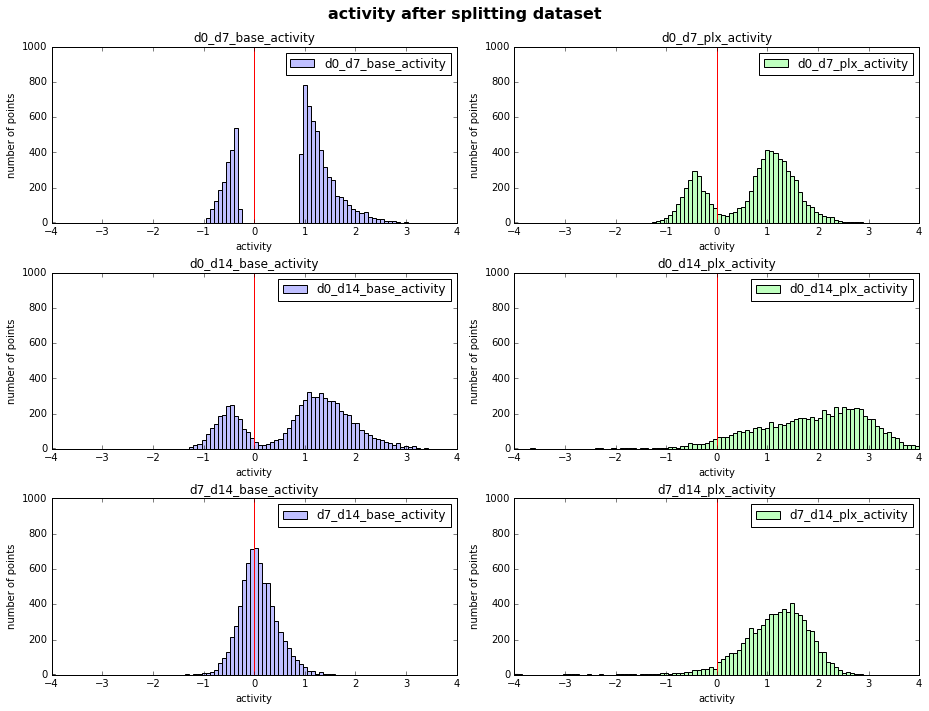

In [556]:
plot_activity_grid('activity after splitting dataset', active_points + same_gene_inactive_points, ylim=1000)

We can see now that we've introduced a dramatic separation in the activity distribution, giving us a clearer binary classification problem -- can we predict into which cluster a given point falls?

To start to answer this, let's examine how the distribution of features differs for points in each cluster.

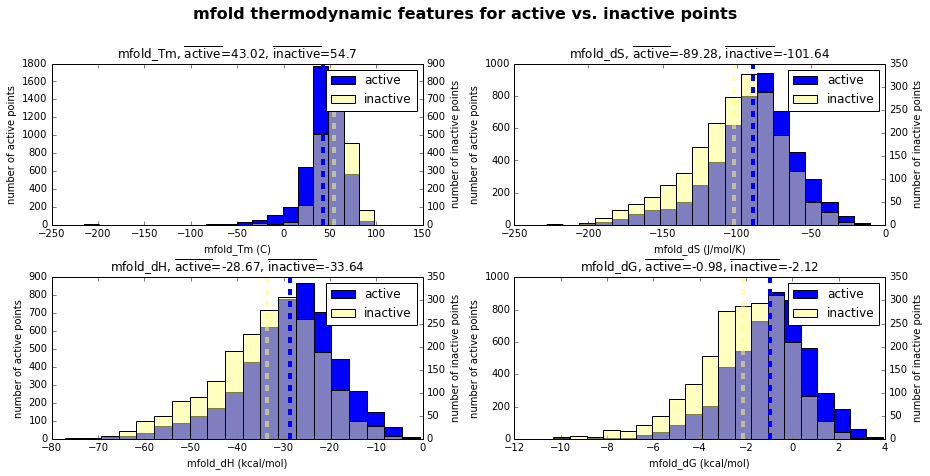

In [558]:
with figure_grid(2, 2, 'mfold thermodynamic features for active vs. inactive points') as fig:
    compare_by('mfold_Tm', subplot=fig.next_subplot())
    compare_by('mfold_dS', subplot=fig.next_subplot())
    compare_by('mfold_dH', subplot=fig.next_subplot())
    compare_by('mfold_dG', subplot=fig.next_subplot())

So it looks like there are differences in the distributions of mfold features for active vs. inactive points. The means are clearly separated, and even though there's still heavy overlap, we do have something to work with.

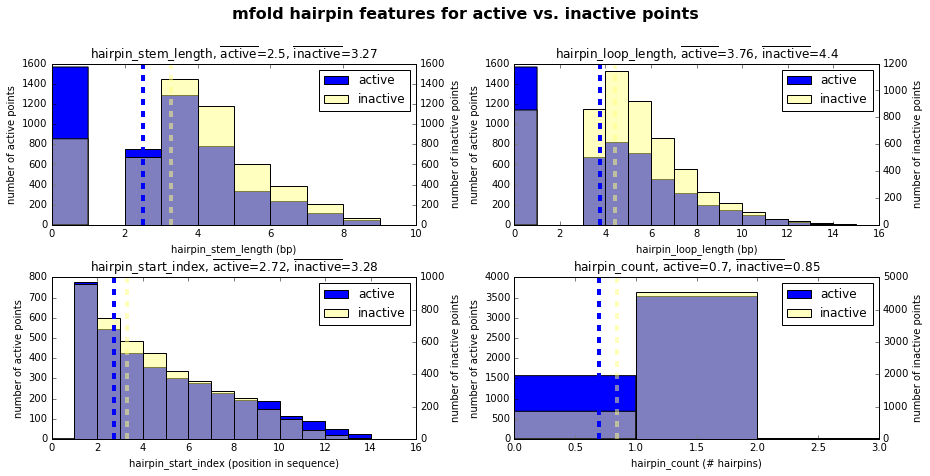

In [531]:
with figure_grid(2, 2, 'mfold hairpin features for active vs. inactive points') as fig:
    compare_by('hairpin_stem_length', bins=10, xrng=(0,10), subplot=fig.next_subplot())
    compare_by('hairpin_loop_length', bins=15, xrng=(0,15), subplot=fig.next_subplot())
    compare_by('hairpin_start_index', bins=15, xrng=(0,15), subplot=fig.next_subplot())
    compare_by('hairpin_count', bins=3, xrng=(0,3), subplot=fig.next_subplot())

There are also differences in the hairpin feature distributions, and they seem to suggest that gRNAs with long hairpins are less suitable for CRISPR. gRNAs with hairpin stem length > 2 bp are less active, while gRNAs with no hairpins or hairpins of stem length <= 2 are more active. This makes some intuitive sense (based on my rough guesses of how overly-complex RNA secondary structure could hinder interaction with Cas9), and suggests that hairpinning might be a (relatively) information-rich feature, though still not predictive on its own.

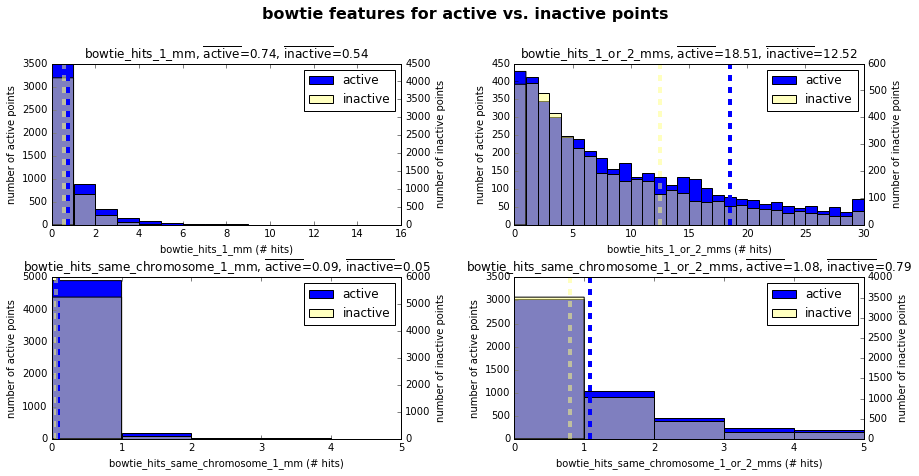

In [532]:
with figure_grid(2, 2, 'bowtie features for active vs. inactive points') as fig:
    compare_by('bowtie_hits_1_mm',                       bins=15, xrng=(0,15), subplot=fig.next_subplot())
    compare_by('bowtie_hits_1_or_2_mms',                 bins=30, xrng=(0,30), subplot=fig.next_subplot())
    compare_by('bowtie_hits_same_chromosome_1_mm',       bins=5,  xrng=(0,5),  subplot=fig.next_subplot())
    compare_by('bowtie_hits_same_chromosome_1_or_2_mms', bins=5,  xrng=(0,5),  subplot=fig.next_subplot())

I didn't expect these results, because one of the things I remember from looking at DESKGEN is that the presence of "off-target" matches reduces the score of CRISPR-suitability for a given gRNA. However, here, gRNAs with more off-target matches are actually _more_ active, consistently across all of the bowtie metrics, which felt counterintuitive to me at first.

One possible explanation is that "off-target" matches don't actually reduce the effectiveness of CRISPR, they actually make it "more" effective in that CRISPR ends up targeting more locations in the genome. And, since CRISPR is knocking out more genes, it's more likely that at least one of those genes is essential to cell functioning, which leads to a greater final activity for that gRNA.

So perhaps these results _do_ make sense. We just have to remember that we're splitting apart the dataset by whether the gRNAs are active or inactive, not precise or imprecise with respect to CRISPR? That might make a classifier for this dataset less useful, though.

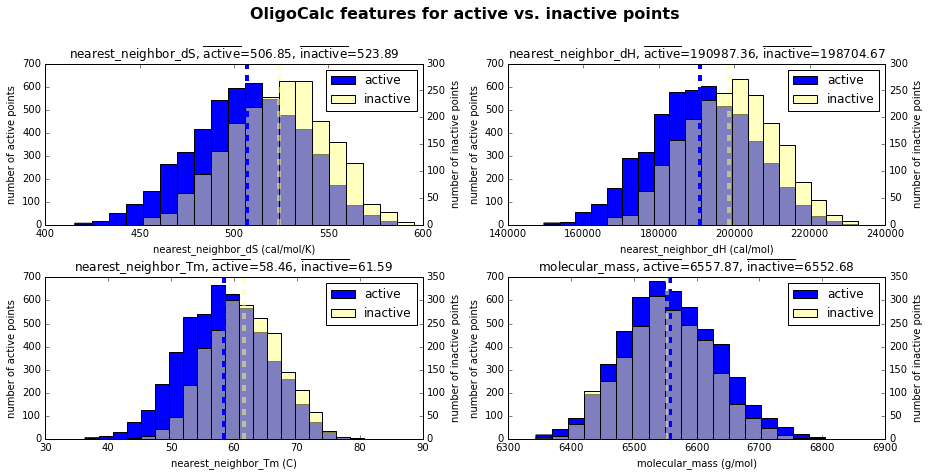

In [559]:
with figure_grid(2, 2, 'OligoCalc features for active vs. inactive points') as fig:
    compare_by('nearest_neighbor_dS', subplot=fig.next_subplot())
    compare_by('nearest_neighbor_dH', subplot=fig.next_subplot())
    compare_by('nearest_neighbor_Tm', subplot=fig.next_subplot())
    compare_by('molecular_mass', subplot=fig.next_subplot())

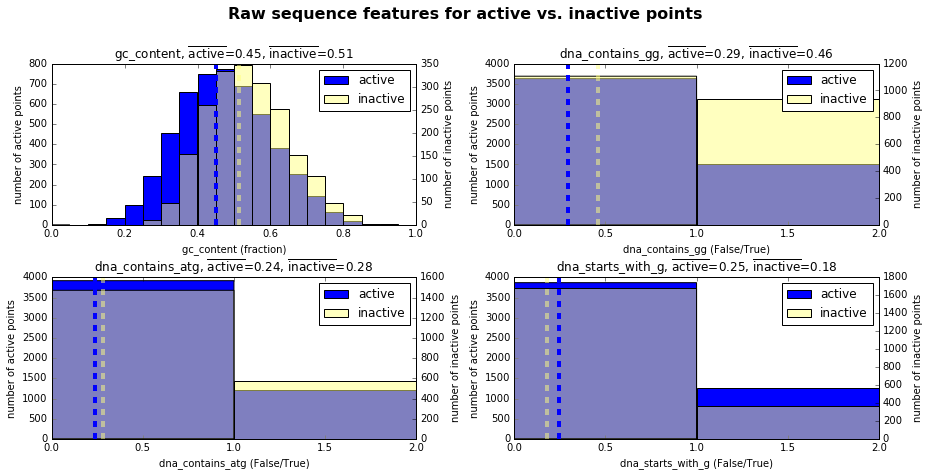

In [560]:
with figure_grid(2, 2, 'Raw sequence features for active vs. inactive points') as fig:
    compare_by('gc_content', xrng=(0,1), subplot=fig.next_subplot())
    compare_by('dna_contains_gg', bins=2, xrng=(0,2), subplot=fig.next_subplot())
    compare_by('dna_contains_atg', bins=2, xrng=(0,2), subplot=fig.next_subplot())
    compare_by('dna_starts_with_g', bins=2, xrng=(0,2), subplot=fig.next_subplot())

There do seem to be some marked differences in GC content (and whether the target sequence contains "GG"), which is interesting.

Now that we've looked at all of these feature groups, and since we've already established (in [Engineering gRNA Features](engineering-features.ipynb)) that there aren't particularly strong correlations across feature groups, we can try to select one from each group to use in classification. I'll try just a basic random forest algorithm from sklearn.

In [537]:
def vectorize(p):
    return [
        p.mfold_dG(),
        p.nearest_neighbor_dS(),
        p.gc_content(),
        p.bowtie_hits_1_or_2_mms(),
        p.hairpin_loop_length()
    ]

X = numpy.array([vectorize(p) for p in active_points + same_gene_inactive_points])

y = numpy.array([1 for p in active_points] + [0 for p in same_gene_inactive_points]) 

# This randomly splits a dataset into training and test sets
def training_test_split(X, y, fraction=0.5):
    n_examples = int(len(y) * fraction)
    indices = list(range(len(y)))
    random.shuffle(indices)
    X_train, y_train = X.take(indices[:n_examples], 0), y.take(indices[:n_examples])
    X_test, y_test = X.take(indices[n_examples:], 0), y.take(indices[n_examples:])
    return X_train, y_train, X_test, y_test

In [561]:
# We'll do 100 different random 50-50 splits of the data into training/test sets,
# and in each case we'll train a random forest and evaluate its performance.
# Then we can see our average accuracy (and if it was consistent across splits).
scores = []
for i in range(100):
    X_train, y_train, X_test, y_test = training_test_split(X, y, 0.5)
    tree = sklearn.ensemble.RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=20)
    tree.fit(X_train, y_train)
    scores.append(tree.score(X_test, y_test))
print(numpy.std(scores))
print(numpy.mean(scores))

0.00538365351665
0.722099247282


It looks like, having split apart our data into buckets based solely on activity, we actually can make at least a weak prediction of which bucket a given point belongs to. I don't know if this could be made into a more general approach, but it seems like there's at least some reason to believe that the engineered gRNA features contain information about the effectiveness of CRISPR for that gRNA.